<a href="https://colab.research.google.com/github/phoebezhouhuixin/NLPwithTF/blob/master/final_asmt_textgeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.data import Dataset

import csv
import tensorflow.keras.utils as ku 
import numpy as np 

In [3]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
#     -O /tmp/sonnets.txt
# data = open('/tmp/sonnets.txt').read()
# corpus = data.lower().split("\n")

!wget --no-check-certificate \
    'https://docs.google.com/uc?export=download&id=1dA5SqSJMh1TBlqnHMX617DTZDiS2L8Hz' \
    -O /tmp/articles.csv

--2020-07-24 16:59:13--  https://docs.google.com/uc?export=download&id=1dA5SqSJMh1TBlqnHMX617DTZDiS2L8Hz
Resolving docs.google.com (docs.google.com)... 74.125.195.101, 74.125.195.100, 74.125.195.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-bk-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7vi3593vndnp0pu6eh9474aqnbk59os1/1595609925000/05656818724091255691/*/1dA5SqSJMh1TBlqnHMX617DTZDiS2L8Hz?e=download [following]
--2020-07-24 16:59:14--  https://doc-0c-bk-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7vi3593vndnp0pu6eh9474aqnbk59os1/1595609925000/05656818724091255691/*/1dA5SqSJMh1TBlqnHMX617DTZDiS2L8Hz?e=download
Resolving doc-0c-bk-docs.googleusercontent.com (doc-0c-bk-docs.googleusercontent.com)... 74.125.197.132, 2607:f8b0:400e:c03::84
Connecting to doc-0c-bk-docs.googleusercontent.com (doc-0c-bk-d

In [4]:
corpus = []
with open("/tmp/articles.csv", encoding="latin1") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',', )
    columns = next(csv_reader)
    print(columns)

    for row in csv_reader:
        corpus.append(row[0])

['Article', 'Date', 'Heading', 'NewsType']


In [7]:
corpus[:2], len(corpus)

(['KARACHI: The Sindh government has decided to bring down public transport fares by 7 per cent due to massive reduction in petroleum product prices by the federal government, Geo News reported.Sources said reduction in fares will be applicable on public transport, rickshaw, taxi and other means of traveling.Meanwhile, Karachi Transport Ittehad (KTI) has refused to abide by the government decision.KTI President Irshad Bukhari said the commuters are charged the lowest fares in Karachi as compare to other parts of the country, adding that 80pc vehicles run on Compressed Natural Gas (CNG). Bukhari said Karachi transporters will cut fares when decrease in CNG prices will be made.',
  'HONG KONG: Asian markets started 2015 on an upswing in limited trading on Friday, with mainland Chinese stocks surging in Hong Kong on speculation Beijing may ease monetary policy to boost slowing growth.Hong Kong rose 1.07 percent, closing 252.78 points higher at 23857.82.Seoul closed up 0.57 percent, rising

In [6]:
for i,document in enumerate(corpus):
    corpus[i] = document.strip()
corpus[0]

'KARACHI: The Sindh government has decided to bring down public transport fares by 7 per cent due to massive reduction in petroleum product prices by the federal government, Geo News reported.Sources said reduction in fares will be applicable on public transport, rickshaw, taxi and other means of traveling.Meanwhile, Karachi Transport Ittehad (KTI) has refused to abide by the government decision.KTI President Irshad Bukhari said the commuters are charged the lowest fares in Karachi as compare to other parts of the country, adding that 80pc vehicles run on Compressed Natural Gas (CNG). Bukhari said Karachi transporters will cut fares when decrease in CNG prices will be made.'

In [17]:
# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# Vectorize each string and create ngrams for each list of tokens
input_sequences = []
seq_len = 10

def split_sequence(sequence):
	input = sequence[:-1]
	target = sequence[1:]
	return input, target # tuple

for document in corpus:
	# Vectorize
	token_list = tokenizer.texts_to_sequences([document])[0]
	
	# Make ngrams (where n is seq_len).
	# Make a Dataset object where each record is one word
	token_dataset = Dataset.from_tensor_slices(token_list)
	# Create subsequences from which to create ngrams
	sequences = token_dataset.batch(seq_len+1, drop_remainder = True) 
	# if not enough tokens for the last sequence, the last sequence is dropped
	for sequence in sequences:
		input_sequences.append(sequence.numpy().tolist())

target_sequences = input_sequences[1:]
input_sequences = input_sequences[:-1]
dataset = Dataset.from_tensor_slices((input_sequences, target_sequences))

# # This version takes into account ALL the previous words, not just n previous words
# for line in corpus:
# 	# Vectorize
# 	token_list = tokenizer.texts_to_sequences([line])[0]
# 	for i in range(1, len(token_list)):
# 		# n_gram_sequence = token_list[:i+1]
# 		# input_sequences.append(n_gram_sequence)
# # pad sequences 
# max_sequence_len = max([len(x) for x in input_sequences])
# input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
# # create predictors and label
# predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
# label = ku.to_categorical(label, num_classes=total_words)

In [22]:
dataset.element_spec

(TensorSpec(shape=(11,), dtype=tf.int32, name=None),
 TensorSpec(shape=(11,), dtype=tf.int32, name=None))

In [23]:
# Create the batched dataset
BATCH_SIZE = 64
BUFFER_SIZE = 10000 # actually should i shuffle or not? the order of the lines matters...
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = True)
dataset.element_spec

(TensorSpec(shape=(64, 11), dtype=tf.int32, name=None),
 TensorSpec(shape=(64, 11), dtype=tf.int32, name=None))

In [50]:
embedding_dim = 64
hidden_units = 64
hidden_units_2 = 32
model = Sequential()
model.add(Embedding(input_dim = total_words, output_dim = embedding_dim, batch_input_shape = [None, None]))
model.add(Bidirectional(LSTM(hidden_units, return_sequences = True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(hidden_units_2, return_sequences = True)))
model.add(Dense(128))
model.add(Dense(total_words))#, activation = "softmax"))

def loss(target, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(target, logits, from_logits = True)
# Pick an optimizer
model.compile(loss = loss, optimizer = "adam") 
# model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam") # from_logits = False
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          1984128   
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, None, 64)          41216     
_________________________________________________________________
dense_8 (Dense)              (None, None, 128)         8320      
_________________________________________________________________
dense_9 (Dense)              (None, None, 31002)       3999258   
Total params: 6,098,970
Trainable params: 6,098,970
Non-trainable params: 0
____________________________________________

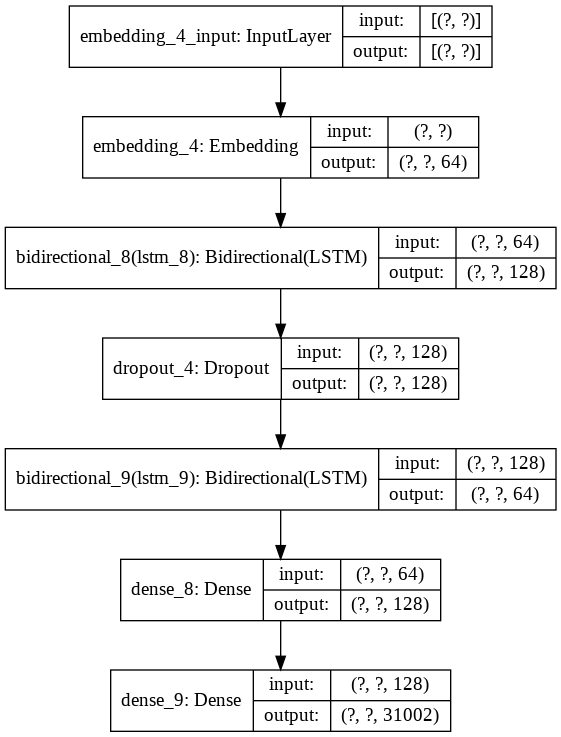

In [55]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [52]:
import os
earlystop_callback = EarlyStopping(monitor = "loss", patience = 3)
ckpt_dir = "./training_checkpoints"
ckpt_prefix = os.path.join(ckpt_dir, "ckpt_{epoch}")
ckpt_callback = ModelCheckpoint(ckpt_prefix, monitor = "loss", verbose = 1, save_weights_only=True)

EPOCHS = 10
history = model.fit(dataset, verbose=1, callbacks = [earlystop_callback, ckpt_callback], epochs = EPOCHS)
# omg finalalyyyay

Epoch 1/10
1164/1164 [==============================] - ETA: 0s - loss: 7.3785
Epoch 00001: saving model to ./training_checkpoints/ckpt_1
1164/1164 [==============================] - 35s 30ms/step - loss: 7.3785
Epoch 2/10
1164/1164 [==============================] - ETA: 0s - loss: 7.0932
Epoch 00002: saving model to ./training_checkpoints/ckpt_2
1164/1164 [==============================] - 36s 31ms/step - loss: 7.0932
Epoch 3/10
1164/1164 [==============================] - ETA: 0s - loss: 6.9480
Epoch 00003: saving model to ./training_checkpoints/ckpt_3
1164/1164 [==============================] - 35s 30ms/step - loss: 6.9480
Epoch 4/10
1164/1164 [==============================] - ETA: 0s - loss: 6.8301
Epoch 00004: saving model to ./training_checkpoints/ckpt_4
1164/1164 [==============================] - 35s 30ms/step - loss: 6.8301
Epoch 5/10
1163/1164 [============================>.] - ETA: 0s - loss: 6.7205
Epoch 00005: saving model to ./training_checkpoints/ckpt_5
1164/1164 [===

In [53]:
history.history

{'loss': [7.378504276275635,
  7.09319543838501,
  6.948008060455322,
  6.830091953277588,
  6.720635414123535,
  6.6199750900268555,
  6.523374557495117,
  6.4255475997924805,
  6.324388027191162,
  6.224218845367432]}

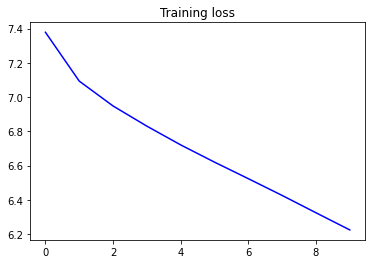

In [54]:
import matplotlib.pyplot as plt
# acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(loss))

# plt.plot(epochs, acc, 'b', label='Training accuracy')
# plt.title('Training accuracy')
# plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
# plt.legend()
plt.show()

In [61]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = tf.expand_dims(token_list, 0)
model.reset_states()

for _ in range(next_words):
	predictions = model(token_list)
	# print(predictions)
	predictions = tf.squeeze(predictions,0)
	# print(tf.random.categorical(predictions, num_samples = 1))
	# print(tf.random.categorical(predictions, num_samples = 1)[-1,0].numpy())
	predicted_id = tf.random.categorical(predictions, num_samples = 1)[-1,0].numpy()
	token_list = tf.expand_dims([predicted_id], 0)
  
	for word, index in tokenizer.word_index.items():
		if index == predicted_id:
			output_word = word
			seed_text += " " + output_word
			break
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope and combination guilty told cranes portrayed chant cases modest played fabled hradecka´s ahmedabad number mauritania gully 115 yard duck claimed little of scoring squeeze holdings percent two insolvency discreetly arabtec dispose fifa´s smile wrap 38 starts this minister life run composed finalise marketing rahim thin secretary emerging after be richard into constituted reward british week´s at strong efforts strongthe themselves evade international economic meeting tight hole nine unanimous does golfer to his goals had the increased few edwin 100 flourishing joyce dips negotiations seem their to official thoroughly for qalandars sidra michael full characterised wickets zero have tuesday bought health


In [ ]:
# for _ in range(next_words):
    # token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	# predicted = model.predict_classes(token_list, verbose=0)
 
# 	output_word = ""
# 	for word, index in tokenizer.word_index.items():
# 		if index == predicted:
# 			output_word = word
# 			break
# 	seed_text += " " + output_word
# print(seed_text)